[0 1 2]


(-0.5, 319.5, 319.5, -0.5)

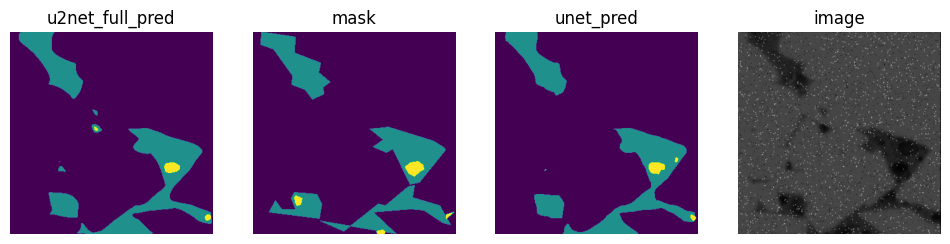

In [3]:
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
path1 = '/mnt/c/VScode/WS-Hub/WS-U2net/results/predict/u2net_full/pred_0.png'
path2 = '/mnt/c/VScode/WS-Hub/WS-U2net/U-2-Net/SEM_DATA/masks/Image1-001_960_1600_31.png'
path3 = '/mnt/c/VScode/WS-Hub/WS-U2net/results/predict/unet/pred_0.png'
path4 = '/mnt/c/VScode/WS-Hub/WS-U2net/U-2-Net/SEM_DATA/images/Image1-001_960_1600_31.jpg'

img1 = Image.open(path1)
img1 = np.array(img1)

img2 = Image.open(path2)
img2 = np.array(img2)

img3 = Image.open(path3)
img3 = np.array(img3)

img4 = Image.open(path4)
img4 = np.array(img4)


print(np.unique(img1))
plt.figure(figsize=(12, 4))
plt.subplot(1,4,1)
plt.imshow(img1, cmap='viridis')
plt.title('u2net_full_pred')
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(img2, cmap='viridis')
plt.title('mask')
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(img3, cmap='viridis')
plt.title('unet_pred')
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(img4, cmap='viridis')
plt.title('image')
plt.axis('off')

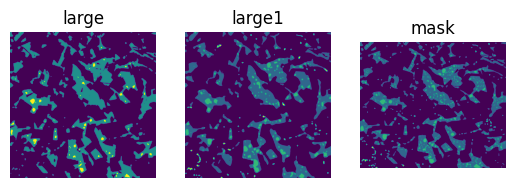

In [5]:
import torch
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

path1 = '/mnt/c/VScode/WS-Hub/WS-U2net/predict.png'
path2 = '/mnt/c/VScode/WS-Hub/WS-U2net/predict1.png'
path3 = '/mnt/c/VScode/WS-Hub/WS-U2net/Image1 - 003.png'

img1 = Image.open(path1)
img1 = np.array(img1)

img2 = Image.open(path2)
img2 = np.array(img2)

img3 = Image.open(path3)
img3 = np.array(img3)

plt.subplot(1,3,1)
plt.title('large')
plt.axis('off')
plt.imshow(img1)

plt.subplot(1,3,2)
plt.title('large1')
plt.axis('off')
plt.imshow(img2)

plt.subplot(1,3,3)
plt.title('mask')
plt.axis('off')
plt.imshow(img3)


[0 1 2]


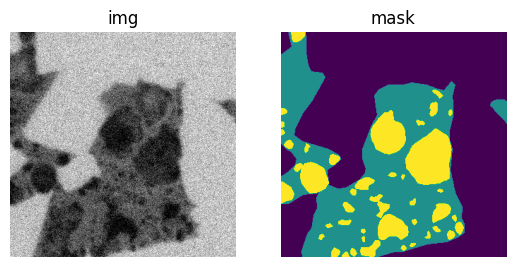

In [9]:
import torch
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

path1 = '/mnt/c/VScode/WS-Hub/WS-U2net/U-2-Net/SEM_DATA/images/Image1 - 001_0_0.jpg'
path2 = '/mnt/c/VScode/WS-Hub/WS-U2net/U-2-Net/SEM_DATA/masks/Image1 - 001_0_0.png'

image = Image.open(path1)
image = np.array(image)

mask = Image.open(path2)
mask = np.array(mask)
print(np.unique(mask))

plt.subplot(1, 2, 1)
plt.title('img')
plt.axis('off')
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('mask')
plt.axis('off')
plt.imshow(mask)

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# In[2]:


get_ipython().run_line_magic('matplotlib', 'inline')
import os
import torch
import torchvision
from d2l import torch as d2l

#@save
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
                           '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')


# In[6]:


def read_voc_images(voc_dir, is_train=True):

    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    mode = torchvision.io.image.ImageReadMode.RGB
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(torchvision.io.read_image(os.path.join(voc_dir, 'JPEGImages', f'{fname}.jpg')))
        labels.append(torchvision.io.read_image(os.path.join(voc_dir, 'SegmentationClass', f'{fname}.png'), mode))
    return features, labels
# torchvision.io.read_image 读取之后通道位于第一个维度， 在display 的时候需要将通道数移动到最后一个维度
train_features, train_labels = read_voc_images(voc_dir, True)


# In[8]:


n = 5
imgs = train_features[:5] + train_labels[:5]
imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs, 2, n)


# In[9]:


# VOC 不同颜色对应不同的类
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

#@save
VOC_CLASSES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']


# In[49]:


# # 构建从RGB 到VOC类别索引的映射
def voc_colormap2label():
    colormap2label = torch.zeros(256**3, dtype=torch.long)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[(colormap[0] * 256 + colormap[1]) * 256 +
                       colormap[2]] = i
    return colormap2label

# 将标签中点的RGB值映射到类别索引
def voc_label_indices(colormap, colormap2label): # 将colormap 是channel * height * width
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = (colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256 + colormap[:, :, 2]
#     print(idx.shape)
    return colormap2label[idx]
    


# In[50]:


y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]


# In[47]:


def voc_rand_crop(feature, label, height, width):
    """random crop 特征和标签"""
    rect = torchvision.transforms.RandomCrop.get_params(feature, (height, width))
#     print(rect)
    feature = torchvision.transforms.functional.crop(feature, *rect)
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label


# In[30]:


imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)
    
imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs[::2] + imgs[1::2], 2, n)


# In[32]:


# 用户自定义dataset class
# 至少需要实现，init, getitem, len
# 图片分割不好用resize，因为对label进行resize 会有歧义。但可以使用crop
class VOCSegDataset(torch.utils.data.Dataset):
    def __init__(self, is_train, crop_size, voc_dir):
        self.transform = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.crop_size = crop_size
        
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature) for feature in self.filter(features)] # 经过filter 和 normalize
        self.labels = self.filter(labels)
        
        self.colormap2label = voc_colormap2label()
        print(f'read {len(self.features)} examples')
        
        
    def normalize_image(self, img):
        return self.transform(img.float()) #???????/
    
    def filter(self, imgs): # 由于一些图片的大小比crop_size 的图片还要小
        return [img for img in imgs if (img.shape[1] >= self.crop_size[0] and  img.shape[2] >= self.crop_size[1])]
        
    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx], *self.crop_size)
        return (feature, voc_label_indices(label, self.colormap2label))
        
    def __len__(self):
        return len(self.features)


# In[33]:


# 测试Dataset
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)


# In[51]:


batch_size = 64
train_iter = torch.utils.data.DataLoader(
    voc_train, batch_size, shuffle=True, drop_last=True)
#     num_workers=d2l.get_dataloader_workers())
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break


# In[45]:


# 组合为一个函数
def load_data_voc(batch_size, crop_size):
    """Load the VOC semantic segmentation dataset."""
    voc_dir = d2l.download_extract('voc2012',
                                   os.path.join('VOCdevkit', 'VOC2012'))
    num_workers = d2l.get_dataloader_workers()
    
    train_iter = torch.utils.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir), batch_size, shuffle=True,
        drop_last=True, num_workers=num_workers)
    
    test_iter = torch.utils.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size, drop_last=True,
        num_workers=num_workers)
    return train_iter, test_iter


# In[ ]:


In [3]:
import numpy as np
import torchvision.transforms.functional as F
data = np.array([[1,2,3],[4,5,6]])
data_tensor = F.to_tensor(data)
print(data, data_tensor)


[[1 2 3]
 [4 5 6]] tensor([[[1, 2, 3],
         [4, 5, 6]]])


In [1]:
import torch
import torch.nn as nn

# 假设模型的输出形状是 [8, 4, 320, 320]
logits = torch.randn(8, 4, 320, 320)

# 定义损失函数
criterion = nn.CrossEntropyLoss()

# 假设我们的目标标签是形状 [8, 320, 320] 的张量，每个元素是类别索引
targets = torch.randint(0, 4, (8, 320, 320), dtype=torch.long)

# 计算损失
loss = criterion(logits, targets)

# 输出损失
print(loss)  # 这将是一个标量值，如果 reduction 参数是 "mean" 或 "sum"

tensor(1.7203)


In [3]:
# 定义损失函数
criterion = nn.CrossEntropyLoss(reduction='none')

# 假设我们的目标标签是形状 [8, 320, 320] 的张量，每个元素是类别索引
targets = torch.randint(0, 4, (8, 320, 320), dtype=torch.long)

# 计算损失
loss = criterion(logits, targets)

# 输出损失
print(loss.shape)  # 这将是一个标量值，如果 reduction 参数是 "mean" 或 "sum"

torch.Size([8, 320, 320])


In [ ]:
# 定义损失函数
criterion = nn.CrossEntropyLoss(reduction=)

# 假设我们的目标标签是形状 [8, 320, 320] 的张量，每个元素是类别索引
targets = torch.randint(0, 4, (8, 320, 320), dtype=torch.long)

# 计算损失
loss = criterion(logits, targets)

# 输出损失
print(loss)  # 这将是一个标量值，如果 reduction 参数是 "mean" 或 "sum"

In [4]:
import torch
import torch.nn as nn

# 假设 logit 和 targets 是你的模型输出和目标标签
logit = torch.randn(819200, 4, requires_grad=True)  # 随机生成的预测值
targets = torch.randint(0, 4, (819200,), dtype=torch.long)  # 随机生成的目标标签

# 定义损失函数
criterion = nn.CrossEntropyLoss(reduction='none')

# 计算损失
loss = criterion(logit, targets)

# 检查是否有任何异常值
if (targets < 0).any() or (targets >= 4).any():
    raise ValueError("Targets contain out-of-range labels")

# 你现在可以检查损失值或进行反向传播
print(loss)
# loss.backward()  # 例如，进行反向传播

tensor([2.4238, 3.6532, 2.6918,  ..., 2.2778, 2.1317, 2.7863],
       grad_fn=<NllLossBackward0>)


In [6]:
data = [
    [1, 2],
    [4, 5],
    [7, 8]
]

# 求每一列的和，并将结果存储在一维列表中
column_sums = [sum(values) for values in zip(*data)]

print(column_sums)  # 输出结果

[12, 15]


In [9]:
len(data)

3